<div>
<img src="https://www.ul.ie/themes/custom/ul/logo.jpg" />
</div>

#**MSc in Artificial Intelligence and Machine Learning**
##CS6271 - Evolutionary Algorithms and Humanoid Robotics 2024
### Kaggle Competition


Module Leader: Conor Ryan

Developers: Rishi Vardhan Kankanala, Kedhar Eashwar Seetammagari

In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 10.4 MB/s eta 0:00:00


#House-keeping: Importing the required libraries

In [ ]:
import sys
from google.colab import drive

drive.mount('/content/drive')

sys.path.append('/content/drive/My Drive/EA')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
import os
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


from deap import base, creator, gp, tools, algorithms # Import algorithms from deap
from deap import creator, base, tools, gp
import operator
import random

Mounted at /content/drive


In [ ]:
sys.path.append('/content/drive/My Drive/grape')
import functions
import algorithms
import grape

In [ ]:

# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

# Loading the data

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/EA/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/EA/test.csv')

# Data Exploration and Pre-processing

In [ ]:
print(train_df.info())
print(train_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5042 entries, 0 to 5041
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HighBP                5042 non-null   float64
 1   HighChol              5042 non-null   float64
 2   CholCheck             5042 non-null   float64
 3   BMI                   5042 non-null   float64
 4   Smoker                5042 non-null   float64
 5   Stroke                5042 non-null   float64
 6   HeartDiseaseorAttack  5042 non-null   float64
 7   PhysActivity          5042 non-null   float64
 8   Fruits                5042 non-null   float64
 9   Veggies               5042 non-null   float64
 10  HvyAlcoholConsump     5042 non-null   float64
 11  AnyHealthcare         5042 non-null   float64
 12  NoDocbcCost           5042 non-null   float64
 13  GenHlth               5042 non-null   float64
 14  MentHlth              5042 non-null   float64
 15  PhysHlth             

In [ ]:
X = train_df.drop('output', axis=1)  # Features
y = train_df['output']               # Target variable

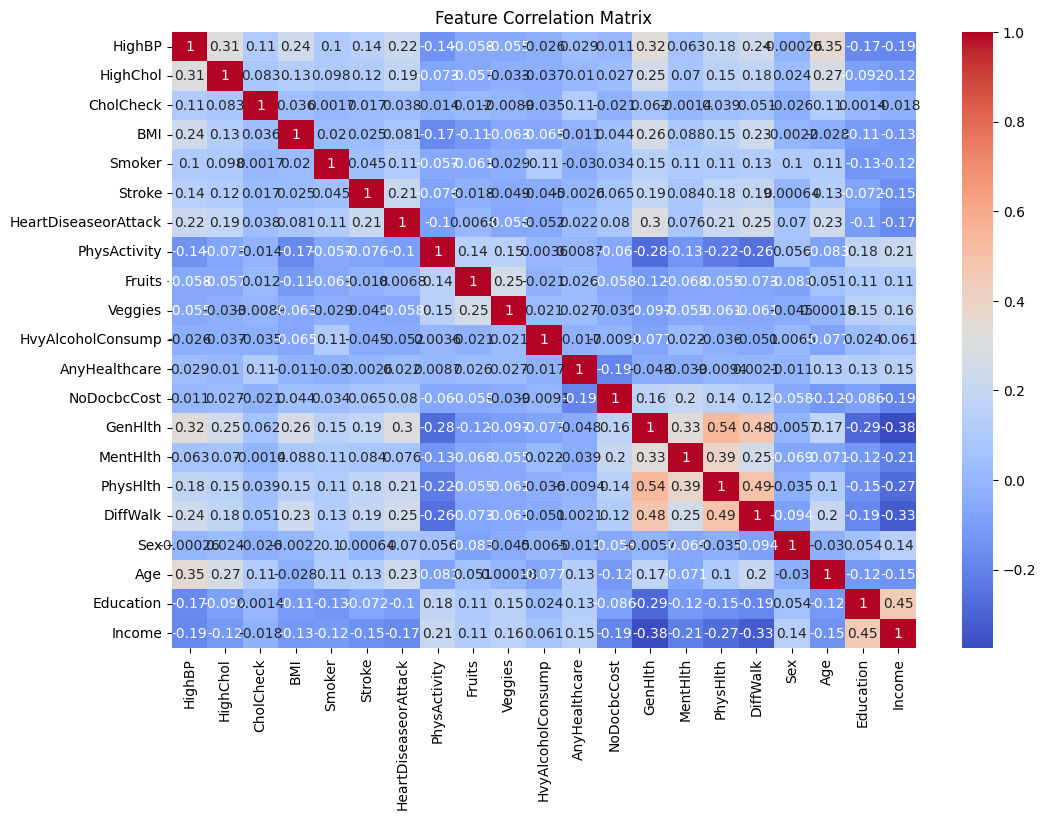

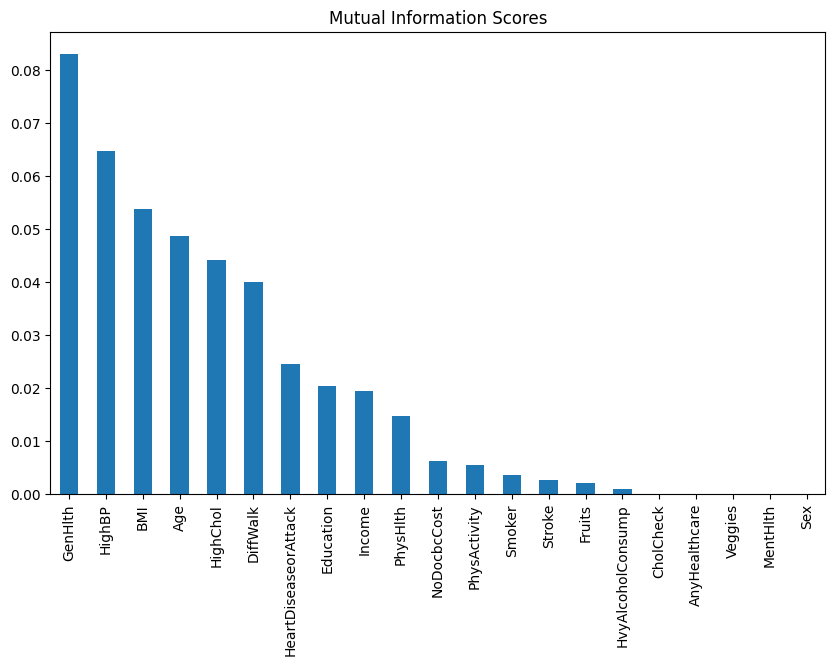

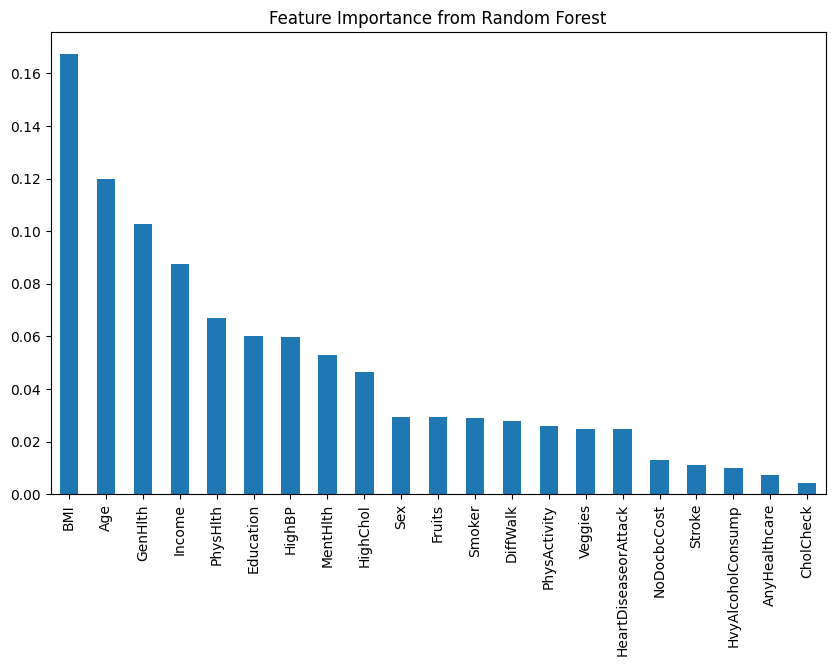

High Correlation Features (> 0.8):
 ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']

Mutual Information Scores:
 GenHlth                 0.083054
HighBP                  0.064812
BMI                     0.053863
Age                     0.048767
HighChol                0.044275
DiffWalk                0.040020
HeartDiseaseorAttack    0.024660
Education               0.020479
Income                  0.019476
PhysHlth                0.014696
NoDocbcCost             0.006307
PhysActivity            0.005435
Smoker                  0.003702
Stroke                  0.002581
Fruits                  0.002151
HvyAlcoholConsump       0.000981
CholCheck               0.000000
AnyHealthcare           0.000000
Veggies                 0.000000
MentHlth                0.000000
Sex           

In [ ]:
X = train_df.drop('output', axis=1)  # Features
y = train_df['output']               # Target variable

# 1. Correlation Analysis
plt.figure(figsize=(12, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# Identify highly correlated features (correlation > 0.8)
high_corr_features = [column for column in correlation_matrix.columns if any(correlation_matrix[column] > 0.8)]

# 2. Mutual Information
mi_scores = mutual_info_classif(X, y)
mi_series = pd.Series(mi_scores, index=X.columns)
mi_series = mi_series.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
mi_series.plot(kind='bar')
plt.title("Mutual Information Scores")
plt.show()

# 3. Feature Importance using Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X, y)
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title("Feature Importance from Random Forest")
plt.show()

# Print the results for further analysis
print("High Correlation Features (> 0.8):\n", high_corr_features)
print("\nMutual Information Scores:\n", mi_series)
print("\nRandom Forest Feature Importances:\n", feature_importances)

In [ ]:
#dropping irrelevant columns
columns_to_drop = ['CholCheck', 'AnyHealthcare', 'NoDocbcCost', 'MentHlth', 'DiffWalk', 'Smoker', 'Education']


train_df = train_df.drop(columns=columns_to_drop)



In [ ]:

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Identify columns
binary_cols = ['HighBP', 'HighChol', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity',
               'Fruits', 'Veggies', 'HvyAlcoholConsump', 'Sex']
continuous_cols = ['BMI', 'PhysHlth', 'Age']
ordinal_cols = ['GenHlth', 'Income']

# Binary columns to integers
X[binary_cols] = X[binary_cols].astype(int)

# Pipeline for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('ord', 'passthrough', ordinal_cols),
        ('cat', OneHotEncoder(), binary_cols)
    ])

# Apply transformation to train and test sets
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Convert to DataFrame
X_train_transformed = pd.DataFrame(X_train_transformed, columns=preprocessor.get_feature_names_out())
X_test_transformed = pd.DataFrame(X_test_transformed, columns=preprocessor.get_feature_names_out())

# Display shapes of transformed datasets
print("X_train_transformed shape:", X_train_transformed.shape)
print("X_test_transformed shape:", X_test_transformed.shape)

X_train_transformed shape: (3378, 23)
X_test_transformed shape: (1664, 23)


In [ ]:
data=X_train_transformed

In [ ]:
data.head()

,num__BMI,num__PhysHlth,num__Age,ord__GenHlth,ord__Income,cat__HighBP_0.0,cat__HighBP_1.0,cat__HighChol_0.0,cat__HighChol_1.0,cat__Stroke_0.0,...,cat__PhysActivity_0.0,cat__PhysActivity_1.0,cat__Fruits_0.0,cat__Fruits_1.0,cat__Veggies_0.0,cat__Veggies_1.0,cat__HvyAlcoholConsump_0.0,cat__HvyAlcoholConsump_1.0,cat__Sex_0.0,cat__Sex_1.0
0,0.076390,-0.540969,-0.147772,3.0,6.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.505039,-0.540969,1.234024,3.0,7.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,2.362516,-0.540969,-2.565915,3.0,6.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,2.791164,-0.540969,-1.875017,3.0,8.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
4,1.505219,-0.540969,1.234024,3.0,2.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


# Genetic Programming Implementation

In [ ]:
# Define fitness function - maximize accuracy
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)
def safe_divide(a, b):
      return a / b if b != 0 else 1
def safe_log(x):
    return np.log(x) if x > 0 else 1
def safe_sqrt(x):
    return np.sqrt(x) if x > 0 else 1
def safe_exp(x):
    return np.exp(x) if x > 0 else 1
 # Configure primitive set
pset = gp.PrimitiveSet("MAIN", X_train_transformed.shape[1])
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(safe_divide, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(operator.abs, 1)
pset.addPrimitive(safe_log, 1)
pset.addPrimitive(safe_sqrt, 1)
pset.addPrimitive(safe_exp, 1)
pset.addPrimitive(np.sin,1)
pset.addPrimitive(np.cos,1)
pset.addPrimitive(np.tan,1)
pset.addEphemeralConstant("rand_const", lambda: random.random())
# Add terminal set (input features)
for i in range(X_train_transformed.shape[1]):
    pset.renameArguments(**{f'ARG{i}': f'feature_{i}'})

# Define toolbox and register functions
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
# Define evaluation function
def evaluate_individual(individual):
    # Transform the individual into a callable function
    func = toolbox.compile(expr=individual)
    # Predict output using GP expression
    predictions = [int(func(*x) > 0.5) for x in X_train_transformed.values]
    return accuracy_score(y_train, predictions),

toolbox.register("evaluate", evaluate_individual)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
# Genetic programming hyperparameters
population_size = 100
num_generations = 100
crossover_prob = 0.6
mutation_prob = 0.4

# Create initial population
population = toolbox.population(n=population_size)

# Run the GP evolution
for gen in range(num_generations):
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < crossover_prob:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < mutation_prob:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the fitness of individuals with invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace population with offspring
    population[:] = offspring

    # Gather and print stats
    fits = [ind.fitness.values[0] for ind in population]
    best_ind = tools.selBest(population, 1)[0]
    print(f"Generation {gen}: Best accuracy = {best_ind.fitness.values[0]}")

# Compile best individual
best_func = toolbox.compile(expr=best_ind)

# Generate predictions for the test set
test_predictions = [int(best_func(*x) > 0.5) for x in X_test_transformed.values]



Generation 0: Best accuracy = 0.6826524570751924
Generation 1: Best accuracy = 0.7057430432208407
Generation 2: Best accuracy = 0.679692125518058
Generation 3: Best accuracy = 0.6805802249851983
Generation 4: Best accuracy = 0.7001184132622854
Generation 5: Best accuracy = 0.7063351095322676
Generation 6: Best accuracy = 0.7063351095322676
Generation 7: Best accuracy = 0.7063351095322676
Generation 8: Best accuracy = 0.7063351095322676
Generation 9: Best accuracy = 0.7069271758436945
Generation 10: Best accuracy = 0.7066311426879811
Generation 11: Best accuracy = 0.7069271758436945
Generation 12: Best accuracy = 0.7089994079336885
Generation 13: Best accuracy = 0.7101835405565423
Generation 14: Best accuracy = 0.7095914742451155
Generation 15: Best accuracy = 0.7095914742451155
Generation 16: Best accuracy = 0.7128478389579633
Generation 17: Best accuracy = 0.7128478389579633
Generation 18: Best accuracy = 0.7140319715808171
Generation 19: Best accuracy = 0.7140319715808171
Generation 

In [ ]:
test_predictions

[0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,


In [ ]:
test_df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,4.0,2.0,2.0,1.0,1.0,8.0,4.0,1.0
1,1.0,0.0,1.0,27.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,14.0,0.0,0.0,11.0,6.0,6.0
2,1.0,1.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,3.0,0.0,0.0,1.0,12.0,6.0,6.0
3,0.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,0.0,9.0,6.0,3.0
4,1.0,1.0,1.0,32.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,5.0,3.0,6.0,1.0,0.0,10.0,5.0,6.0


# Calculating accuracy for the training subset

In [ ]:
from sklearn.metrics import accuracy_score


subset_size = int(0.2 * len(X_train_transformed))
subset_indices = random.sample(range(len(X_train_transformed)), subset_size)

X_subset = X_train_transformed.iloc[subset_indices]
y_subset = y_train.iloc[subset_indices]

# Generate predictions for the subset
subset_predictions = [int(best_func(*x) > 0.5) for x in X_subset.values]

# Calculate accuracy
subset_accuracy = accuracy_score(y_subset, subset_predictions)

print(f"Accuracy on the subset: {subset_accuracy}")

Accuracy on the subset: 0.725925925925926


# The test dataset

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/EA/test.csv')

In [ ]:
# Drop the same columns as in the training data
test_df = test_df.drop(columns=columns_to_drop)

# Convert binary columns to integers (if needed)
test_df[binary_cols] = test_df[binary_cols].astype(int)

# Apply the preprocessor (fitted on training data) to the test data
X_test_final = preprocessor.transform(test_df)

# Convert to DataFrame (optional)
X_test_final = pd.DataFrame(X_test_final, columns=preprocessor.get_feature_names_out())

# Now X_test_final contains the preprocessed test data ready for prediction
print("X_test_final shape:", X_test_final.shape)
X_test_final.head()

X_test_final shape: (95804, 23)


,num__BMI,num__PhysHlth,num__Age,ord__GenHlth,ord__Income,cat__HighBP_0.0,cat__HighBP_1.0,cat__HighChol_0.0,cat__HighChol_1.0,cat__Stroke_0.0,...,cat__PhysActivity_0.0,cat__PhysActivity_1.0,cat__Fruits_0.0,cat__Fruits_1.0,cat__Veggies_0.0,cat__Veggies_1.0,cat__HvyAlcoholConsump_0.0,cat__HvyAlcoholConsump_1.0,cat__Sex_0.0,cat__Sex_1.0
0,-0.209375,-0.330185,-0.147772,4.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,-0.352258,0.934520,0.888575,3.0,6.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2,-0.352258,-0.540969,1.234024,1.0,6.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
3,-0.352258,-0.540969,0.197677,3.0,3.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.362156,0.091383,0.543126,5.0,6.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


# Predictions for the test dataset

In [ ]:

# Generate predictions for the final test set using the best GP function
final_predictions = [int(best_func(*x) > 0.5) for x in X_test_final.values]

# Create a submission DataFrame
submission_df = pd.DataFrame({'index': test_df.index, 'output': final_predictions})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)

# Download the submission file
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Chart saved as 'gp_results_comparison.png'


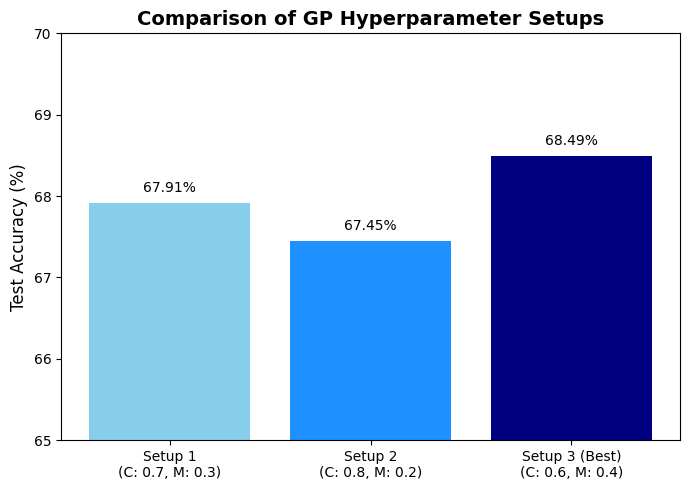

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# --- Data taken directly from your presentation slides ---
setup_labels = ['Setup 1\n(C: 0.7, M: 0.3)', 
                'Setup 2\n(C: 0.8, M: 0.2)', 
                'Setup 3 (Best)\n(C: 0.6, M: 0.4)']
accuracies = [67.91, 67.45, 68.49]

# --- Create the Bar Chart ---
fig, ax = plt.subplots(figsize=(7, 5))
colors = ['skyblue', 'dodgerblue', 'navy']
bars = ax.bar(setup_labels, accuracies, color=colors)

# --- Add titles and labels for clarity ---
ax.set_ylabel('Test Accuracy (%)', fontsize=12)
ax.set_title('Comparison of GP Hyperparameter Setups', fontsize=14, fontweight='bold')
ax.set_ylim(65, 70)  # Focus the y-axis to better show the differences

# --- Add the accuracy value on top of each bar ---
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.1, f'{yval}%', ha='center', va='bottom')

# --- Save the figure to your project folder ---
plt.tight_layout()
plt.savefig('gp_results_comparison.png')
print("Chart saved as 'gp_results_comparison.png'")

plt.show()